In [70]:
import pybel
import os
import openbabel
from metatlas import create_launchpad, create_obmol, create_orca_input_string, \
OBUFFOptimize, OrcaOptimize, ComputeProtonationEnergy
from IPython.display import SVG, HTML
import imolecule
import molvs
from pprint import pprint
from fireworks import Firework, Workflow, FWorker
from fireworks.core.rocket import Rocket
from fireworks.core.rocket_launcher import launch_rocket
from mendeleev import element

def draw_html(pymol):
    return HTML(imolecule.draw(pymol.clone, 
                               format="pybel", 
                               display_html=False))

LOCAL_DB_CONFIG = '/home/bkrull/.fireworks/local_db.ini'
lpad = create_launchpad(LOCAL_DB_CONFIG)

In [62]:
mol = pybel.readfile('xyz', '/home/bkrull/Documents/data/qm9/dsgdb9nsd_090177.xyz').next()
mol.write('smi').split('\t')[0]
mol.formula
draw_html(mol)

In [84]:
mol = pybel.readfile('xyz', '/home/bkrull/Documents/data/qm9/dsgdb9nsd_090177.xyz').next()

orca_strings = []
mols = []
print mol.formula
print mol.atoms[-1].coords
    
for atom in mol.atoms:
    if atom.atomicnum in [7, 8, 15, 16]:
        print 'Atom #{} is {} atom with\n coords {}'.format(atom.idx, element(atom.atomicnum), atom.coords)
        obmol = create_obmol(mol)
        a = obmol.NewAtom()
#         a.SetFormalCharge(atom.formalcharge+1)
        a.SetAtomicNum(1)
        a.SetVector(*atom.coords)
        a.SetVector(a.GetVector().GetX() + 0.2, 
                    a.GetVector().GetY() + 0.2,
                    a.GetVector().GetZ() + 0.2)
        print 'New Proton is #{} with info {} and\n coords ({}, {}. {})'.format(a.GetIdx(), 
                                                                      element(a.GetAtomicNum()),
                                                                      a.GetVector().GetX(),
                                                                      a.GetVector().GetY(),
                                                                      a.GetVector().GetZ())
        obmol.AddBond(atom.idx, a.GetIdx(), 1)
        obmol.SetTotalCharge(mol.charge + 1)
        tmp_pymol = pybel.Molecule(obmol)
        tmp_pymol.localopt()
        
        mols.append(tmp_pymol)

        orca_string, _ = create_orca_input_string(tmp_pymol)
        orca_strings.append(orca_string)

draw_html(mol)
for i, mol in enumerate(mols):
    print mol.formula
    draw_html(mol)

    for atom in mol.atoms:
        print 'atom#{}: {}'.format(atom.idx, atom)
    
    mol.write('xyz', '/home/bkrull/Desktop/mol{}.xyz'.format(i), overwrite=True)

C7H10O2
(-1.458512084, -4.124054443, -0.5299022186)
Atom #1 is 8 O Oxygen atom with
 coords (-0.6179908654, 1.1694625638, -1.0689009303)
New Proton is #20 with info 1 H Hydrogen and
 coords (-0.4179908654, 1.3694625638. -0.8689009303)
Atom #8 is 8 O Oxygen atom with
 coords (0.425612108, -3.2460898425, -0.9790845529)
New Proton is #20 with info 1 H Hydrogen and
 coords (0.625612108, -3.0460898425. -0.7790845529)
C7H32O2+
atom#1: Atom: 8 (-0.62 1.17 -1.07)
atom#2: Atom: 6 (-0.07 0.25 -0.13)
atom#3: Atom: 6 (-1.24 -0.66 0.35)
atom#4: Atom: 6 (-1.19 -1.88 -0.56)
atom#5: Atom: 6 (-1.11 -1.70 -2.07)
atom#6: Atom: 6 (0.14 -1.87 -1.27)
atom#7: Atom: 6 (0.98 -0.71 -0.78)
atom#8: Atom: 8 (0.43 -3.25 -0.98)
atom#9: Atom: 6 (-0.80 -3.31 -0.19)
atom#10: Atom: 1 (0.10 1.71 -1.41)
atom#11: Atom: 1 (0.38 0.80 0.71)
atom#12: Atom: 1 (-1.07 -0.97 1.39)
atom#13: Atom: 1 (-2.18 -0.10 0.33)
atom#14: Atom: 1 (-1.42 -2.52 -2.71)
atom#15: Atom: 1 (-1.33 -0.71 -2.43)
atom#16: Atom: 1 (1.57 -0.19 -1.55)
atom#1

In [17]:
mol = pybel.readstring('smi', 'O[C@H]1C[C@@]23C[C@]2(C1)OC3')
mol.formula

'C7H10O2'

In [3]:
orca = OrcaOptimize()
orca._

## Update all the completed jobs for running neutrals

In [ ]:
for fw_id in completed:
    fwdict = lpad.get_fw_dict_by_id(fw_id)
    lpad.rerun_fw(fw_id, recover_mode='prev_dir')
    parent_xyz = fwdict['name']+'.xyz'
    mol = pybel.readfile('xyz', parent_xyz).next()
    
    protonated_energies = []
    for optpath in ['stored_data']['energies']: #already counts the number of protonated sites
        egy = optpath[-1]
        protonated_energies.append(egy)    
        
    lpad.update_spec([launch_id], {"_tasks.0._fw_name": "OBUFFOptimize",
                       "_tasks.0.smiles_string": parent_xyz,
                       '_tasks.0.strtype': 'xyz',
                       "_tasks.1._fw_name": "OrcaOptimize",
                       '_tasks.2._fw_name': 'ComputeProtonationEnergy',
                       '_tasks.2.protonated_mol_energies': protonated_energies,
                       '_tasks.2.neutral_mol_energy': neutral_egy})

### Test fw update

In [ ]:
# fw_id = 1
lpad.rerun_fw(1)
fwdict = lpad.get_fw_dict_by_id(fw_id)

protonated_energies = []
for optpath in fwdict['archived_launches'][1]['action']['stored_data']['energies']: #already counts the number of protonated sites
    egy = optpath[-1]
    protonated_energies.append(egy) 
    
neutral_egy = protonated_energies[-1]

lpad.update_spec([1], {"_tasks.0._fw_name": "OBUFFOptimize",
                       "_tasks.0.smiles_string": '/home/bkrull/Documents/data/qm9/dsgdb9nsd_090177.xyz',
                       '_tasks.0.strtype': 'xyz',
                       "_tasks.1._fw_name": "OrcaOptimize",
                       '_tasks.2._fw_name': 'ComputeProtonationEnergy',
                       '_tasks.2.protonated_mol_energies': protonated_energies,
                       '_tasks.2.neutral_mol_energy': neutral_egy})
launch_rocket(lpad, fw_id=1)

In [85]:
# for id in lpad.get_fw_ids({'state': 'COMPLETED'}):
lpad.mark_fizzled(1)
lpad.rerun_fw(1, recover_mode='prev_dir')

fwdict = lpad.get_fw_dict_by_id(fw_id)

protonated_energies = []
for optpath in fwdict['archived_launches'][1]['action']['stored_data']['energies']: #already counts the number of protonated sites
    egy = optpath[-1]
    protonated_energies.append(egy) 
    
neutral_egy = protonated_energies[-1]

lpad.update_spec([1], {"_tasks.0._fw_name": "OBUFFOptimize",
                       "_tasks.0.smiles_string": '/home/bkrull/Documents/data/qm9/dsgdb9nsd_090177.xyz',
                       '_tasks.0.strtype': 'xyz',
                       "_tasks.1._fw_name": "OrcaOptimize",
                       '_tasks.2._fw_name': 'ComputeProtonationEnergy',
                       '_tasks.2.protonated_mol_energies': protonated_energies,
                       '_tasks.2.neutral_mol_energy': neutral_egy})
data = lpad.get_fw_dict_by_id(1)
original_spec = data['spec']['_tasks']

launch_rocket(lpad, fw_id=1)
len(data['archived_launches'])

2018-05-02 10:24:07,781 INFO Launching Rocket
2018-05-02 10:24:09,912 INFO RUNNING fw_id: 1 in directory: /home/bkrull/devel/MetAtlas
2018-05-02 10:24:10,937 INFO Task started: OBUFFOptimize.
2018-05-02 10:24:11,044 INFO Task completed: OBUFFOptimize 
2018-05-02 10:24:11,050 INFO Task started: OrcaOptimize.
2018-05-02 10:24:11,056 INFO Task completed: OrcaOptimize 
2018-05-02 10:24:11,093 INFO Task started: ComputeProtonationEnergy.
2018-05-02 10:24:11,095 INFO Task completed: ComputeProtonationEnergy 
2018-05-02 10:24:12,626 INFO Rocket finished


17

In [91]:
fwdict = lpad.get_fw_dict_by_id(1)

fwdict['launches'][0]['action']['stored_data']['energies']

[-57.620229446238795,
 -57.628246084866106,
 -57.6304914733075,
 -57.63269654949269,
 -57.6339663566512,
 -57.63501795963893,
 -57.63557200890335,
 -57.636027871464705,
 -57.636448018646206,
 -57.6368487372406,
 -57.63717539494559,
 -57.63745458106871,
 -57.63771856499778,
 -57.63797764238811,
 -57.63823120305136,
 -57.638482273525256,
 -57.63873457450913,
 -57.63899250503371,
 -57.63922944559269,
 -57.639408482692005,
 -57.63953809004903,
 -57.63966037503684,
 -57.639770261981425,
 -57.6398673283619,
 -57.639952856441454,
 -57.64002606278339,
 -57.64009144041282,
 -57.640146039856916,
 -57.64019199762686,
 -57.64023440928898,
 -57.64027325680942,
 -57.640304439520804,
 -57.64032857128959,
 -57.64035147751028,
 -57.64037598588223,
 -57.640398233184754,
 -57.640415742847466,
 -57.64043257658861,
 -57.640455675182324,
 -57.64048976739389,
 -57.6405309379945,
 -57.64056769806251,
 -57.64059411979258,
 -57.64061664190103,
 -57.64064110969437,
 -57.64066627097225,
 -57.64068952866083,
 -57.

## launch rockets here

### Rerunning to generate neutral molecule's energy

want to in-(db-)place update the entry with a new task computing the optimized structure, energy of the neutral molecule.

#### Accessing  the protonated molecules' energies
```python
fwdict['archived_launches'][launch_number]['action']['stored_data']['energies'][protonated_mol_number][:]
```

This will return the list of energies along the optimization path for molecule=protonated_mol_number of the launch=launch_number.

#### Accessing the neutral molecules' energies
Since this will be the most recent launch

```python
fwdict['launches'][0]['action']['stored_data']['energies'][:]
```


In [103]:
def make_xyz_from_stored_data(atoms, coords):
    xyz = '{}\n\n'.format(len(atoms))
    
    for i, atom in enumerate(atoms):
        xyz += '{} {} {} {}\n'.format(atom[0],
                                      coords[i][0], coords[i][1], coords[i][2])
        
    xyz += '\n'
    return xyz

In [104]:
fract = 1

for id in lpad.get_fw_ids({'state': 'COMPLETED'}):
    data = lpad.get_fw_dict_by_id(id)
    name = data['name'].split('/')[-1]
    stored_data = data['launches'][0]['action']['stored_data']
    
    conformers = stored_data['atom_list']
    nconformers = len(conformers)
    
    try:
        atoms = conformers[0]
    except IndexError:
        continue
    
    for confid in range(nconformers):      
        steps = stored_data['coords'][confid]
        with open('qm9struct/{}/{}-{}.xyz'.format(fract, name, confid), 'w') as f:
            for step in range(len(steps)):
                coords = steps[step]
                xyz = make_xyz_from_stored_data(atoms, coords)
        
                f.write(xyz)
                
    if id%5000 == 0:
        fract +=1
        os.mkdir('qm9struct/{}'.format(fract))

In [138]:
mol = pybel.readfile('xyz', '/home/bkrull/Documents/data/qm9/dsgdb9nsd_111111.xyz').next()

In [128]:
mol = openbabel.OBMol()
smi = molecules.loc[0, 'original_smiles']
new_pymol = pybel.readstring('smi', smi)
new_pymol.make3D()
draw_html(pymol)

In [127]:

new_pymol = pybel.Molecule(mol)
new_pymol.localopt()
draw_html(new_pymol)

In [133]:
def new_obmol(pymol):
    mol = openbabel.OBMol()

    for atom in pymol.atoms:
        a = mol.NewAtom()
        a.SetAtomicNum(atom.atomicnum)
        a.SetVector(atom.coords[0], atom.coords[1], atom.coords[2])
        
    return mol

def single_deprotonations:
    single_protonations = []
    print 'Total atoms {}, charge {}'.format(len(new_pymol.atoms), new_pymol.charge)

    for atom in new_pymol.atoms:
        if atom.atomicnum in [7,8,15,16]:
            mol = new_obmol(new_pymol)
            a = mol.NewAtom()
            a.SetAtomicNum(1)
            a.SetVector(atom.coords[0]+0.2, 
                        atom.coords[1]+0.2, 
                        atom.coords[2]+0.2)
            mol.AddBond(atom.idx, new_pymol.atoms[-1].idx+1, 1)
            mol.SetTotalCharge(new_pymol.charge+1)
            tmp_pymol = pybel.Molecule(mol)
            tmp_pymol.localopt()
            print 'Total atoms {}, charge {}'.format(len(tmp_pymol.atoms), tmp_pymol.charge)
            single_protonations.append(tmp_pymol)

    orca_strings = []
    for molecule in single_protonations:
        orca_string, _ = create_orca_input_string(molecule)
        orca_strings.append(orca_string)
        
    return orca_strings

Total atoms 47, charge -1
Total atoms 48, charge 0
Total atoms 48, charge 0
Total atoms 48, charge 0
Total atoms 48, charge 0
Total atoms 48, charge 0


In [134]:
draw_html(single_protonations[0])

In [135]:
draw_html(single_protonations[1])

In [78]:
mol.addh()
mol.make3D()
print len(mol.atoms), mol.charge
draw_html(mol)

47 -1


In [79]:
mol.OBMol.AddAtom(hydrogen)
mol.make3D()
mol.localopt(steps=1000)
print len(mol.atoms), mol.charge
draw_html(mol)

49 -1


In [85]:
single_protonations = []

for atom in mol.atoms:
    if atom.atomicnum > 1:
        tmpmol = mol
        tmpmol.OBMol.AddAtom(hydrogen)
        tmpmol.OBMol.NewBond(atom.idx)
        tmpmol.OBMol.SetCharge(mol.charge+1)
        single_protonations.append(tmpmol)

NotImplementedError: Wrong number or type of arguments for overloaded function 'OBMol_NewBond'.
  Possible C/C++ prototypes are:
    OpenBabel::OBMol::NewBond()
    OpenBabel::OBMol::NewBond(unsigned long)


Atom C3, valence 2, hybridization 3, nonHneighbors 2, formalcharge 0
Atom C3, valence 2, hybridization 3, nonHneighbors 2, formalcharge 1
49


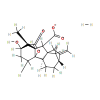

In [49]:
mol = pybel.readstring('smi', smi)

mol.OBMol.AddAtom(hydrogen)
atom = mol.atoms[2]
print "Atom {}, valence {}, hybridization {}, nonHneighbors {}, formalcharge {}".format(
        atom.type, atom.valence, atom.hyb, atom.heavyvalence, atom.formalcharge)
atom.OBAtom.SetFormalCharge(1)
print "Atom {}, valence {}, hybridization {}, nonHneighbors {}, formalcharge {}".format(
        atom.type, atom.valence, atom.hyb, atom.heavyvalence, atom.formalcharge)

mol.addh()
print len(mol.atoms)
mol

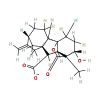

In [23]:
mol

In [15]:
for atom in mol:
    print "Atom {}, valence {}, hybridization {}, nonHneighbors {}".format(
        atom.type, atom.valence, atom.hyb, atom.heavyvalence)

Atom C2, valence 1, hybridization 2, nonHneighbors 1
Atom C2, valence 3, hybridization 2, nonHneighbors 3
Atom C3, valence 2, hybridization 3, nonHneighbors 2
Atom C3, valence 4, hybridization 3, nonHneighbors 4
Atom C3, valence 2, hybridization 3, nonHneighbors 2
Atom C3, valence 4, hybridization 3, nonHneighbors 3
Atom H, valence 1, hybridization 0, nonHneighbors 1
Atom C3, valence 2, hybridization 3, nonHneighbors 2
Atom C3, valence 2, hybridization 3, nonHneighbors 2
Atom C3, valence 4, hybridization 3, nonHneighbors 3
Atom H, valence 1, hybridization 0, nonHneighbors 1
Atom C3, valence 4, hybridization 3, nonHneighbors 4
Atom C3, valence 2, hybridization 3, nonHneighbors 2
Atom C3, valence 2, hybridization 3, nonHneighbors 2
Atom C3, valence 4, hybridization 3, nonHneighbors 3
Atom H, valence 1, hybridization 0, nonHneighbors 1
Atom O3, valence 1, hybridization 3, nonHneighbors 1
Atom C3, valence 4, hybridization 3, nonHneighbors 4
Atom C3, valence 1, hybridization 3, nonHneighbor

In [14]:
mol.conformers

<Swig Object of type 'std::vector< double *,std::allocator< double * > > *' at 0x7ff73656b480>